## 네이버 영화 리뷰 데이터 전처리

In [2]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from tqdm import tqdm
from sklearn.model_selection import train_test_split


In [3]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x7974dd9ce770>)

In [4]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

In [5]:
print('훈련용 리뷰 개수 :', len(train_data))

훈련용 리뷰 개수 : 150000


In [6]:
train_data[:5]

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [7]:
# document 열과 label 열의 중복을 제외한 값의 개수
train_data['document'].nunique(), train_data['label'].nunique()

(146182, 2)

In [8]:
train_data.drop_duplicates(subset=['document'], inplace=True)
print('중복 제거후 훈련용 데이터의 개수', len(train_data))

중복 제거후 훈련용 데이터의 개수 146183


<Axes: xlabel='label'>

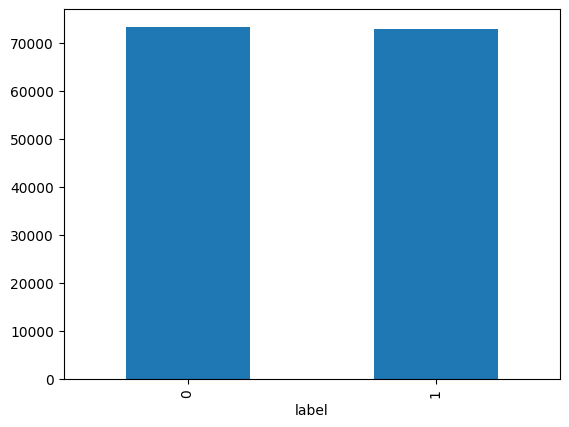

In [9]:
train_data['label'].value_counts().plot(kind = 'bar')

In [10]:
train_data.info() # NULL이 있는 데이터가 1개 있다

<class 'pandas.core.frame.DataFrame'>
Index: 146183 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        146183 non-null  int64 
 1   document  146182 non-null  object
 2   label     146183 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.5+ MB


In [11]:
train_data = train_data[train_data.document.notnull()] # NULL이 있는 데이터는 그냥 제거

In [12]:
train_data.info() # NULL이 있는 데이터가 없어지면서 총 146183에서 146182로 줄었다

<class 'pandas.core.frame.DataFrame'>
Index: 146182 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        146182 non-null  int64 
 1   document  146182 non-null  object
 2   label     146182 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.5+ MB


In [13]:
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [14]:
# 한글과 공백을 제외하고 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True)
train_data[:5]

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [15]:
train_data['document'] = train_data['document'].str.replace('^ +', "", regex=True) # 공백으로 시작하는 부분을 제거
train_data['document'].replace('', np.nan, inplace=True) # 그랬는데 값이 없으면, 애초에 공백으로만 적힌, 제거해야할 데이터
print(train_data.isnull().sum())

id            0
document    789
label         0
dtype: int64


In [16]:
train_data = train_data.dropna(how = 'any')
print(len(train_data))

145393


In [17]:
# 테스트 데이터에 대해서도 같은 전처리를 진행
test_data.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True) # 정규 표현식 수행
test_data['document'] = test_data['document'].str.replace('^ +', "", regex=True) # 공백은 empty 값으로 변경
test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 48852


In [ ]:
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab_light_220429.sh

In [23]:
# 토크나이징
from konlpy.tag import Mecab
mecab = Mecab()
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']

X_train = []
for sentence in tqdm(train_data['document']):
  tokenized_sentence = mecab.morphs(sentence) # 토큰화
  stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords]
  X_train.append(stopwords_removed_sentence)

100%|██████████| 145393/145393 [00:11<00:00, 12639.95it/s]


In [24]:
print(X_train[:3])

[['아', '더', '빙', '진짜', '짜증', '나', '네요', '목소리'], ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍', '않', '구나'], ['너무', '재', '밓었다그래서보는것을추천한다']]


In [25]:
X_test = []
for sentence in tqdm(test_data['document']):
    tokenized_sentence = mecab.morphs(sentence) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_test.append(stopwords_removed_sentence)

100%|██████████| 48852/48852 [00:03<00:00, 15774.36it/s]


In [26]:
# train, test split
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=0, stratify=y_train)

In [27]:
print('--------학습 데이터의 비율-----------')
print(f'부정 리뷰 = {round(np.sum(y_train==0)/len(y_train) * 100,3)}%')
print(f'긍정 리뷰 = {round(np.count_nonzero(y_train)/len(y_train) * 100,3)}%')
print('--------검증 데이터의 비율-----------')
print(f'부정 리뷰 = {round(np.sum(y_valid==0)/len(y_valid) * 100,3)}%')
print(f'긍정 리뷰 = {round(np.count_nonzero(y_valid)/len(y_valid) * 100,3)}%')
print('--------테스트 데이터의 비율-----------')
print(f'부정 리뷰 = {round(np.sum(y_test==0)/len(y_test) * 100,3)}%')
print(f'긍정 리뷰 = {round(np.count_nonzero(y_test)/len(y_test) * 100,3)}%')

--------학습 데이터의 비율-----------
부정 리뷰 = 50.238%
긍정 리뷰 = 49.762%
--------검증 데이터의 비율-----------
부정 리뷰 = 50.239%
긍정 리뷰 = 49.761%
--------테스트 데이터의 비율-----------
부정 리뷰 = 49.808%
긍정 리뷰 = 50.192%


In [28]:
# 단어 집합 만들기
from collections import Counter

word_list = []
for sent in X_train:
    for word in sent:
      word_list.append(word)

word_counts = Counter(word_list)
print('총 단어수 :', len(word_counts))

총 단어수 : 45296


In [29]:
print('훈련 데이터에서의 단어 영화의 등장 횟수 :', word_counts['영화'])
print('훈련 데이터에서의 단어 공감의 등장 횟수 :', word_counts['공감'])

훈련 데이터에서의 단어 영화의 등장 횟수 : 45791
훈련 데이터에서의 단어 공감의 등장 횟수 : 756


In [30]:
vocab = sorted(word_counts, key=word_counts.get, reverse=True)
print('등장 빈도수 상위 10개 단어')
print(vocab[:10])

등장 빈도수 상위 10개 단어
['영화', '보', '있', '없', '좋', '나', '었', '만', '는데', '너무']


In [31]:
threshold = 3
total_cnt = len(word_counts) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 45296
등장 빈도가 2번 이하인 희귀 단어의 수: 26104
단어 집합에서 희귀 단어의 비율: 57.62981278700106
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.2768285068857192


In [32]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
vocab_size = total_cnt - rare_cnt
vocab = vocab[:vocab_size]
print('단어 집합의 크기 :', len(vocab))

단어 집합의 크기 : 19192


In [33]:
# 단어를 index로 변환해줄 딕셔너리 세팅
word_to_index = {}
# Padding과 Unknown을 먼저 추가
word_to_index['<PAD>'] = 0
word_to_index['<UNK>'] = 1

In [34]:
for index, word in enumerate(vocab) :
  word_to_index[word] = index + 2

In [35]:
vocab_size = len(word_to_index)
print('패딩 토큰과 UNK 토큰을 고려한 단어 집합의 크기 :', vocab_size)

패딩 토큰과 UNK 토큰을 고려한 단어 집합의 크기 : 19194


In [36]:
print('단어 <PAD>와 맵핑되는 정수 :', word_to_index['<PAD>'])
print('단어 <UNK>와 맵핑되는 정수 :', word_to_index['<UNK>'])
print('단어 영화와 맵핑되는 정수 :', word_to_index['영화'])

단어 <PAD>와 맵핑되는 정수 : 0
단어 <UNK>와 맵핑되는 정수 : 1
단어 영화와 맵핑되는 정수 : 2


In [37]:
# 텍스트 데이터(단어들)에 대한 정수 인코딩을 수행
def texts_to_sequences(tokenized_X_data, word_to_index):
  encoded_X_data = []
  for sent in tokenized_X_data:
    index_sequences = []
    for word in sent:
      try:
          index_sequences.append(word_to_index[word])
      except KeyError:
          index_sequences.append(word_to_index['<UNK>'])
    encoded_X_data.append(index_sequences)
  return encoded_X_data

encoded_X_train = texts_to_sequences(X_train, word_to_index)
encoded_X_valid = texts_to_sequences(X_valid, word_to_index)
encoded_X_test = texts_to_sequences(X_test, word_to_index)

# 상위 샘플 2개 출력
for sent in encoded_X_train[:2]:
  print(sent)

[924, 1866, 128, 7, 80, 48, 34]
[2415, 3138, 4, 2095, 422, 87, 5768, 19, 307]


In [38]:
# 반대로 decoding을 위해 정수 index에 대응되는 단어를 복원(반환)하는 딕셔너리 세팅
index_to_word = {}
for key, value in word_to_index.items():
    index_to_word[value] = key

In [39]:
decoded_sample = [index_to_word[word] for word in encoded_X_train[0]]
print('기존의 첫번째 샘플 :', X_train[0])
print('복원된 첫번째 샘플 :', decoded_sample)

기존의 첫번째 샘플 : ['이야', '어쩜', '이렇게', '나', '지루', '할', '수']
복원된 첫번째 샘플 : ['이야', '어쩜', '이렇게', '나', '지루', '할', '수']


리뷰의 최대 길이 : 74
리뷰의 평균 길이 : 12.296705469676908


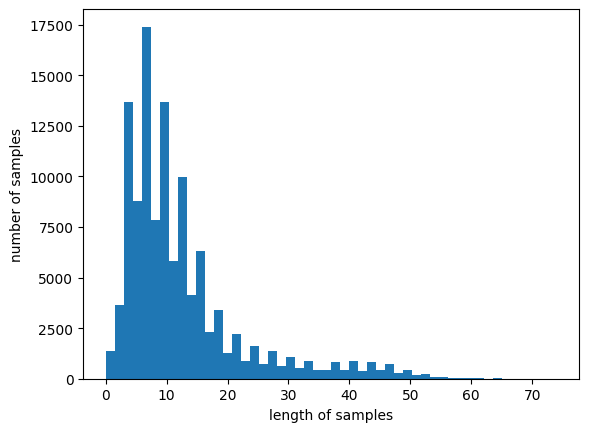

In [40]:
# 최대 길이의 문장으로 모든 문장들에 대한 Padding을 수행
print('리뷰의 최대 길이 :',max(len(review) for review in encoded_X_train))
print('리뷰의 평균 길이 :',sum(map(len, encoded_X_train))/len(encoded_X_train))
plt.hist([len(review) for review in encoded_X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [41]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 92.49703389101914


In [42]:
def pad_sequences(sentences, max_len):
  features = np.zeros((len(sentences), max_len), dtype=int)
  for index, sentence in enumerate(sentences):
    if len(sentence) != 0:
      features[index, :len(sentence)] = np.array(sentence)[:max_len]
  return features

padded_X_train = pad_sequences(encoded_X_train, max_len=max_len)
padded_X_valid = pad_sequences(encoded_X_valid, max_len=max_len)
padded_X_test = pad_sequences(encoded_X_test, max_len=max_len)

print('훈련 데이터의 크기 :', padded_X_train.shape)
print('검증 데이터의 크기 :', padded_X_valid.shape)
print('테스트 데이터의 크기 :', padded_X_test.shape)

print('첫번째 샘플의 길이 :', len(padded_X_train[0]))
print('첫번째 샘플 :', padded_X_train[0])

훈련 데이터의 크기 : (116314, 30)
검증 데이터의 크기 : (29079, 30)
테스트 데이터의 크기 : (48852, 30)
첫번째 샘플의 길이 : 30
첫번째 샘플 : [ 924 1866  128    7   80   48   34    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F

USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")
print("cpu와 cuda 중 다음 기기로 학습함:", device)

cpu와 cuda 중 다음 기기로 학습함: cuda


In [44]:
train_label_tensor = torch.tensor(np.array(y_train))
valid_label_tensor = torch.tensor(np.array(y_valid))
test_label_tensor = torch.tensor(np.array(y_test))
print(train_label_tensor[:5])

tensor([0, 1, 1, 1, 1])


In [45]:
class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(TextClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)            # embedding_dim 차원으로 임베딩
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)    # 임베딩 입력을 바탕으로 LSTM의 hidden_dim 차원을 출력, batch를 맨 앞으로
        self.fc = nn.Linear(hidden_dim, output_dim)                         # 마지막 Fully Connected Layer에 hidden_dim차원을 입력으로 output_dim 차원의 출력을 결정

    def forward(self, x):
        # x: (batch_size, seq_length)
        embedded = self.embedding(x)  # embedded.shape = (batch_size, seq_length, embedding_dim)

        # LSTM은 (hidden state, cell state)의 튜플을 반환합니다
        lstm_out, (hidden, cell) = self.lstm(embedded)
        # lstm_out: (batch_size, seq_length, hidden_dim) = 모든 timestep의 hidden state를 반환(입력 시퀀스의 각 시간별 LSTM의 출력)
        # hidden: (1, batch_size, hidden_dim) = 마지막 time step의 각 LSTM의 hidden state

        last_hidden = hidden.squeeze(0)  # (batch_size, hidden_dim)
        # squeeze(0) : tensor의 첫번째 차원이 1일 경우 이를 제거하는 용도
        
        logits = self.fc(last_hidden)  # (batch_size, output_dim)
        return logits

In [46]:
encoded_train = torch.tensor(padded_X_train).to(torch.int64)
train_dataset = torch.utils.data.TensorDataset(encoded_train, train_label_tensor)
train_dataloader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=32)

encoded_test = torch.tensor(padded_X_test).to(torch.int64)
test_dataset = torch.utils.data.TensorDataset(encoded_test, test_label_tensor)
test_dataloader = torch.utils.data.DataLoader(test_dataset, shuffle=True, batch_size=1)

encoded_valid = torch.tensor(padded_X_valid).to(torch.int64)
valid_dataset = torch.utils.data.TensorDataset(encoded_valid, valid_label_tensor)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, shuffle=True, batch_size=1)

In [47]:
total_batch = len(train_dataloader)
print('총 배치의 수 : {}'.format(total_batch))

총 배치의 수 : 3635


In [48]:
embedding_dim = 100 # 19194개의 어휘를 가지고 있으며 하나의 단어당 100차원으로 표현
hidden_dim = 128    # LSTM의 hidden state의 차원의 크기
output_dim = 2      # LSTM 출력을 입력으로 받은 Fully connected의 출력 차원(모델의 최종 출력의 차원)
                    # 긍정/부정의 binary classification이지만 각각에 대한 확률을 softmax로 계산하고 그 중 높은 확률값을 고르는 방식으로 하기 위해 output_dim을 2로 설정
                    # 이는 output_dim을 1로 설정하고 loss function으로 BCELoss를 사용하여 sigmoid를 취해 0.5 이상이면 긍정, 그 아래면 부정으로 판단하는 것과 크게 다르지 않다
learning_rate = 0.01
num_epochs = 10

model = TextClassifier(vocab_size, embedding_dim, hidden_dim, output_dim)
model.to(device)

TextClassifier(
  (embedding): Embedding(19194, 100)
  (lstm): LSTM(100, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

In [49]:
criterion = nn.CrossEntropyLoss() # 비록 binary classification이지만 output_dim을 2로 설정했으므로 softmax를 취하는 cross entropy loss를 사용한다
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [50]:
def calculate_accuracy(logits, labels):
    # logits: 모델이 예측한 로짓값이 클래스의 개수만큼 리스트 안에 계산되어 있고 그러한 값이 batch_size만큼 있다 --> shape = [batch_size, num_classes](2차원)
    # _, predicted = torch.max(logits, 1)
    predicted = torch.argmax(logits, dim=1)         # dim=1은 두번째 차원인 num_classes에 대해 가장 큰 로짓값을 갖는 인덱스를 반환하도록 한다 --> predicted.shape = [batch_size] # batch의 각 샘플마다 가장 큰 로짓값을 갖는 인덱스로 반환
    correct = (predicted == labels).sum().item()    # 예측 인덱스와 실제 레이블(인덱스)를 비교해서 같은 것은 True로 반환되고 그 개수를 새어 item()을 통해 파이썬 정수형으로 반환
    total = labels.size(0)                          # labels는 [batch_size]이므로 현재 배치의 샘플 개수를 size(0)으로 얻고 있다
    accuracy = correct / total
    return accuracy

In [51]:
def evaluate(model, valid_dataloader, criterion, device):
    val_loss = 0
    val_correct = 0
    val_total = 0

    model.eval()
    with torch.no_grad():
        # 데이터로더로부터 배치 크기만큼의 데이터를 연속으로 로드
        for batch_X, batch_y in valid_dataloader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            # 모델의 예측값
            logits = model(batch_X) # 긍정, 부정에 대한 로짓(일종의 점수)로 반환

            # CrossEntropy의 softmax로 인해 logits이 확률값(probability)로 변환되고 label과의 차이를 바탕으로 loss가 계산
            loss = criterion(logits, batch_y)   

            # 정확도와 손실을 계산함
            val_loss += loss.item()
            val_correct += calculate_accuracy(logits, batch_y) * batch_y.size(0)
            val_total += batch_y.size(0)

    val_accuracy = val_correct / val_total
    val_loss /= len(valid_dataloader)

    return val_loss, val_accuracy

In [52]:
num_epochs = 5

# Training loop
best_val_loss = float('inf')

# Training loop
for epoch in range(num_epochs):
    # Training
    train_loss = 0
    train_correct = 0
    train_total = 0
    model.train()
    for batch_X, batch_y in train_dataloader:
        # Forward pass
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        # batch_X.shape == (batch_size, max_len)
        logits = model(batch_X)

        # Compute loss
        loss = criterion(logits, batch_y)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate training accuracy and loss
        train_loss += loss.item()
        train_correct += calculate_accuracy(logits, batch_y) * batch_y.size(0)
        train_total += batch_y.size(0)

    train_accuracy = train_correct / train_total
    train_loss /= len(train_dataloader)

    # Validation
    val_loss, val_accuracy = evaluate(model, valid_dataloader, criterion, device)

    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    # 검증 손실이 최소일 때 체크포인트 저장
    if val_loss < best_val_loss:
        print(f'Validation loss improved from {best_val_loss:.4f} to {val_loss:.4f}. 체크포인트를 저장합니다.')
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model_checkpoint.pth')

Epoch 1/5:
Train Loss: 0.4711, Train Accuracy: 0.7524
Validation Loss: 0.3648, Validation Accuracy: 0.8359
Validation loss improved from inf to 0.3648. 체크포인트를 저장합니다.
Epoch 2/5:
Train Loss: 0.3197, Train Accuracy: 0.8629
Validation Loss: 0.3403, Validation Accuracy: 0.8509
Validation loss improved from 0.3648 to 0.3403. 체크포인트를 저장합니다.
Epoch 3/5:
Train Loss: 0.2604, Train Accuracy: 0.8928
Validation Loss: 0.3486, Validation Accuracy: 0.8510
Epoch 4/5:
Train Loss: 0.2039, Train Accuracy: 0.9198
Validation Loss: 0.3724, Validation Accuracy: 0.8493
Epoch 5/5:
Train Loss: 0.1550, Train Accuracy: 0.9414
Validation Loss: 0.4213, Validation Accuracy: 0.8481


In [53]:
# 모델 로드
model.load_state_dict(torch.load('best_model_checkpoint.pth'))

# 모델을 device에 올립니다.
model.to(device)

<ipython-input-53-4cd7d8c4ec6d>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model_checkpoint.pth'))


TextClassifier(
  (embedding): Embedding(19194, 100)
  (lstm): LSTM(100, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

In [54]:
# 검증 데이터에 대한 정확도와 손실 계산
val_loss, val_accuracy = evaluate(model, valid_dataloader, criterion, device)

print(f'Best model validation loss: {val_loss:.4f}')
print(f'Best model validation accuracy: {val_accuracy:.4f}')

Best model validation loss: 0.3403
Best model validation accuracy: 0.8509


In [55]:
# 테스트 데이터에 대한 정확도와 손실 계산
test_loss, test_accuracy = evaluate(model, test_dataloader, criterion, device)

print(f'Best model test loss: {test_loss:.4f}')
print(f'Best model test accuracy: {test_accuracy:.4f}')

Best model test loss: 0.3441
Best model test accuracy: 0.8494


In [56]:
index_to_tag = {0 : '부정', 1 : '긍정'}

def predict(text, model, word_to_index, index_to_tag):
    # Set the model to evaluation mode
    model.eval()

    # Tokenize the input text
    tokens = mecab.morphs(text) # 토큰화
    tokens = [word for word in tokens if not word in stopwords] # 불용어 제거
    token_indices = [word_to_index.get(token, 1) for token in tokens] # 각 토큰을 정수 인코딩하고 만약 OOV이면 1번 인덱스(<UNK>)으로 설정

    # Convert tokens to tensor
    input_tensor = torch.tensor([token_indices], dtype=torch.long).to(device)  # (1, seq_length)

    # Pass the input tensor through the model
    with torch.no_grad():
        logits = model(input_tensor)  # (1, output_dim)

    # 로짓들 중에서 가장 큰 로짓값을 가진 인덱스로 모델의 예측 label을 계산
    predicted_index = torch.argmax(logits, dim=1)

    # 예측 레이블(인덱스)를 인덱스에서 해당 인덱스의 결과로 전환
    predicted_tag = index_to_tag[predicted_index.item()]

    return predicted_tag

In [57]:
test_input = "이 영화 개꿀잼 ㅋㅋㅋ"
predict(test_input, model, word_to_index, index_to_tag)

'긍정'

In [58]:
test_input = "와 개쩐다 정말 세계관 최강자들의 영화다"
predict(test_input, model, word_to_index, index_to_tag)

'긍정'

In [59]:
test_input = "감독 뭐하는 놈이냐?"
predict(test_input, model, word_to_index, index_to_tag)

'부정'